# E-commerce Data Analysis with BigQuery
**Author**: Jean-Jacques Chabut

**Date**: January 2026

**Dataset**: `bigquery-public-data.thelook_ecommerce`

**Tools**: BigQuery, SQL, Looker Studio

**Objective**: Optimize queries using partitions/clusters,  analyze key metrics.


## Table of Contents
1. [Context and Dataset](#context)
2. [Table Optimization](#optimization)
   - 2.1 [Orders Table](#orders)
   - 2.2 [Events Table](#events)
   - 2.3 [Products Table](#products)
3. [Key Analyses](#analyses)
   - 3.1 [Revenue Comparison](#revenue)
   - 3.2 [Order status](#status)
   - 3.3 [Top Products](#top-products)
4. [Visualizations (Looker Studio)](#visualizations)
5. [Performance gain](#performance)
6. [Conclusion](#conclusion)


## 1. Context and Dataset <a name="context"></a>
### 1.1 Dataset Overview
- **Source**: Public BigQuery dataset (`bigquery-public-data.thelook_ecommerce`).
- **Limitations & Data Biases**:

This dataset is synthetic and does not reflect real-world e-commerce behavior.

As a result:
  - Customer behavior may appear more regular than in real production data
  - Seasonality effects are limited
  - Some metrics (returns, conversion, engagement) should be interpreted cautiously.

The purpose of this analysis is not to produce business recommendations, but to demonstrate analytical reasoning, SQL modeling, and time-series analysis techniques.
- **Tables**:
  - `Orders` (125k rows): Order (status, date, user ID).
  - `Order items` (180k rows): Order item ( product, sale price).
  - `Users` (100k rows): Users (age, gender, country).
  - `Events` (high volume): User interactions (click, purchase, date, session id).
  - `Products` (29k rows): Product catalog.
- **Goal**:
  - Reduce query costs and improve performance using partitions/clusters.
  - Identify few KPIs and produce dashboard.

### 1.2 Business themes
- Sales growth
- Seasonality
- Product page effectiveness


### 1.3 Optimization Strategy
- **Partitions**: On date columns (`created_at`, `event_timestamp`).
- **Clusters**: On frequently filtered/grouped columns (`status`, `user_id`, `product_id`).
- **Materialized Views**: For recurrent calculations.


## 2. Table Optimization <a name="optimization"></a>

### Orders Table <a name="orders"></a>
**Objective**: Speed up queries on statuses and dates.

**Optimizations**:
- **Partition**: `DATE(created_at)`. Remove time using DATE function
- **Cluster**: `status`, `user_id`.

```sql
CREATE OR REPLACE TABLE Ecommerce_datapipeline.raw_orders
  PARTITION BY order_dt
  CLUSTER BY status, user_id
AS
SELECT
  order_id,
  user_id,
  status,
  gender,
  DATE(created_at) As order_dt,
  created_at,
  returned_at,
  shipped_at,
  delivered_at,
  num_of_item
FROM `bigquery-public-data.thelook_ecommerce.orders`;
```


In [ ]:
-- Example: uses partition + cluster

SELECT
  event_type,
  COUNT(DISTINCT user_id) AS users
FROM Ecommerce.events_par_date_clu_type
WHERE DATE(event_timestamp) BETWEEN '2020-01-01' AND '2020-01-31'
GROUP BY event_type;


### Events Table <a name="events"></a>
**Objective**: Reduce costs for high-volume event data.

**Optimizations**:
- **Partition**: `DATE(event_timestamp)`. Remove time using DATE function
- **Cluster**: `event_type`, `traffic_source`.
```sql
CREATE OR REPLACE TABLE Ecommerce_datapipeline.raw_events
PARTITION BY DATE(event_timestamp)
CLUSTER BY event_type, traffic_source
AS SELECT * FROM `bigquery-public-data.thelook_ecommerce.events`;
```


## 3. Key analysis <a name="optimization"></a>

### 3.1 Revenue Comparison <a name="revenue"></a>

**Objective**: Compare revenue 2024 vs 2025.

**Conclusion**:
- Year-end sales peak.
- Almost 300% increase of December revenue compared to the previous year.

**SQL**:
```SQL
WITH monthly_revenue AS (
  SELECT
    CONCAT(
      CAST(EXTRACT(YEAR FROM o.created_at) AS STRING),
      '-',
      LPAD(CAST(EXTRACT(MONTH FROM o.created_at) AS STRING), 2, '0')
    ) AS year_month,
    ROUND(SUM(oi.sale_price)) AS Revenue
  FROM Ecommerce_datapipeline.raw_orders o
  JOIN `bigquery-public-data.thelook_ecommerce.order_items` oi
    USING (order_id)
  WHERE o.order_dt BETWEEN DATE('2024-01-01') AND DATE('2025-12-31')
  GROUP BY 1
),

ranked_revenue AS (
  SELECT
    year_month,
    Revenue,
    LAG(Revenue, 12) OVER (ORDER BY year_month) AS PreviousYearRevenue
  FROM monthly_revenue
)

SELECT
  year_month,
  Revenue AS CurrentRevenue,
  PreviousYearRevenue,
  Revenue - PreviousYearRevenue AS RevenueDifference,
  ROUND((Revenue - PreviousYearRevenue) / PreviousYearRevenue * 100, 2) AS RevenueGrowthPercent
FROM ranked_revenue
WHERE year_month LIKE '2025-%'
ORDER BY year_month;
```


### 3.2 Order status <a name="status"></a>

**Objective**: Overview of order life cycle

**Conclusion**:
- A return rate of 10% is well below the average observed in e-commerce, which is around 20%.
- Half of the orders sent do not change to Complete status => Check if transporter update can be improved.
- 20% of the orders are still in status Processing => Check the percentage of these orders that are confirmed.

**SQL**:
```SQL
-- Function : Be able to sort status by weight (order life cycle)

CREATE OR REPLACE FUNCTION Ecommerce_datapipeline.StatusOrderWeight(
  status STRING)
RETURNS INT64
AS (
  CASE
    WHEN status = 'Cancelled' THEN 0
    WHEN status = 'Processing' THEN 1
    WHEN status = 'Returned' THEN 2
    WHEN status = 'Shipped' THEN 3
    WHEN status = 'Complete' THEN 4
    ELSE -1
    END
);

SELECT
  status,
  Ecommerce_datapipeline.StatusOrderWeight(status) AS weight,
  COUNT(*) AS numberOfOrder
FROM `bigquery-public-data.thelook_ecommerce.orders`
GROUP BY status;
````



### 3.3 Top products <a name="top-products"></a>

**Objective**: Compare the most viewed products with the best-selling products.

**Conclusion**:
A table of raw data sorted by use case and limited to 20 lines allows you to:
- High-potential products: Lots of views but few sales → analyze to understand the bottleneck.
- Underexposed products: Few views but good sales → promote more.
- Conversion rate: A key indicator for measuring the effectiveness of the product page.


**SQL**:
```SQL
CREATE TABLE Ecommerce_datapipeline.dim_prod_conv_rate AS (
  WITH product_views AS (
      SELECT CAST(SUBSTR(uri, 10, LENGTH(uri)) AS INT64) AS product_id,
       COUNT(1) AS view_count
      FROM Ecommerce_datapipeline.raw_events e
      WHERE event_type = 'product'
      AND DATE(created_at) BETWEEN DATE('2025-01-01') AND DATE('2025-12-31')
      GROUP BY product_id
      HAVING COUNT(1) >= 10
    ),

product_sales AS (
  SELECT
    product_id,
    COUNT(DISTINCT order_id) AS order_count,
    COUNT(1) AS units_sold
  FROM `bigquery-public-data.thelook_ecommerce.order_items`
  WHERE DATE(created_at) BETWEEN DATE('2025-01-01') AND DATE('2025-12-31')
  GROUP BY product_id
)

SELECT
  COALESCE(pv.product_id, ps.product_id) AS productid,
  pr.name AS product_name,
  IFNULL(pv.view_count, 0) AS view_count,
  IFNULL(ps.order_count, 0) AS order_count,
  ROUND(IFNULL(ps.order_count, 0) / NULLIF(IFNULL(pv.view_count, 0), 0),2) AS conversion_rate
FROM product_views pv
FULL OUTER JOIN product_sales ps
  ON pv.product_id = ps.product_id
JOIN `bigquery-public-data.thelook_ecommerce.products` pr
 ON pr.id = pv.product_id
)
````




## 4. Visualization (Looker Studio) <a name="visualizations"></a>

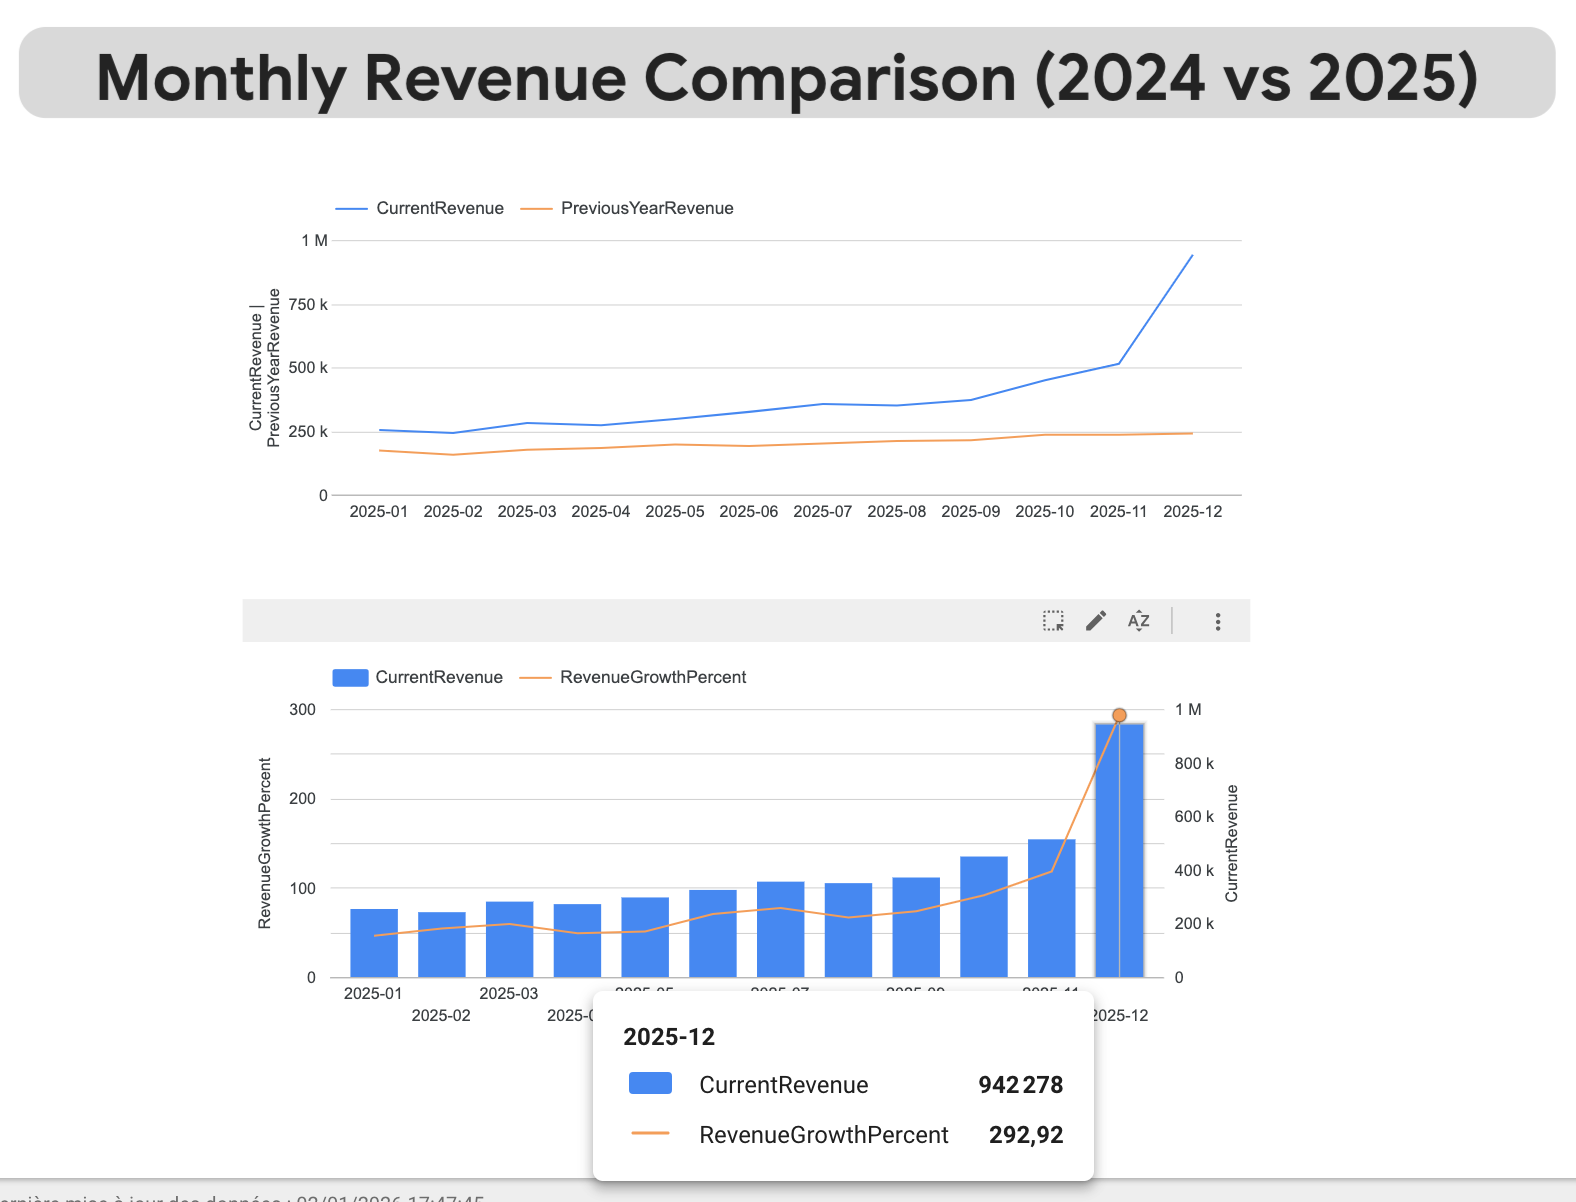

## 5. Performance gain <a name="performance"></a>

```SQL
 SELECT order_id, user_id FROM `bigquery-public-data.thelook_ecommerce.orders`
WHERE created_at = PARSE_TIMESTAMP('%Y-%m-%d %H:%M:%S %Z', '2023-02-26 01:45:03 UTC');
````
Bytes processed 2.86 MB, Bytes billed 10MB, Elapsed time 314ms

```SQL
SELECT order_id, user_id, order_dt FROM Ecommerce_datapipeline.raw_orders
WHERE created_at = PARSE_TIMESTAMP('%Y-%m-%d %H:%M:%S %Z', '2023-02-26 01:45:03 UTC');
```
Bytes processed 1.03 KB,  Bytes billed 10MB, Elapsed time 233ms

## 6. Conclusion<a name="conclusion"></a>
This project demonstrates an end-to-end analytical workflow:
- translating business questions into analytical queries.
- building time-series metrics using window functions.
- optimizing queries with partitioning and clustering.
- connecting SQL outputs to data visualization.

While the dataset has known limitations, the project reflects my current approach to data analysis and analytics engineering.

Future projects will focus more on data modeling, pipeline design, and production-oriented use cases.